<a href="https://colab.research.google.com/github/yejoonlee/NCPW/blob/main/NCPW_DL/classify_log/TS_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U tensorflow==2.4.0

  Using cached tensorflow-2.4.0-cp37-cp37m-manylinux2010_x86_64.whl (394.7 MB)
  Using cached numpy-1.19.5-cp37-cp37m-manylinux2010_x86_64.whl (14.8 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.5
    Uninstalling numpy-1.21.5:
      Successfully uninstalled numpy-1.21.5
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.8.0
    Uninstalling tensorflow-2.8.0:
      Successfully uninstalled tensorflow-2.8.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
!pip show numpy

Name: numpy
Version: 1.19.5
Summary: NumPy is the fundamental package for array computing with Python.
Home-page: https://www.numpy.org
Author: Travis E. Oliphant et al.
Author-email: None
License: BSD
Location: /usr/local/lib/python3.7/dist-packages
Requires: 
Required-by: xgboost, xarray, wordcloud, torchvision, torchtext, tifffile, thinc, Theano-PyMC, tensorflow, tensorflow-probability, tensorflow-hub, tensorflow-datasets, tensorboard, tables, statsmodels, spacy, sklearn-pandas, seaborn, scs, scipy, scikit-learn, scikit-image, resampy, qdldl, PyWavelets, python-louvain, pystan, pysndfile, pymc3, pyerfa, pyemd, pycocotools, pyarrow, plotnine, patsy, pandas, osqp, opt-einsum, opencv-python, opencv-contrib-python, numexpr, numba, nibabel, netCDF4, moviepy, mlxtend, mizani, missingno, matplotlib, matplotlib-venn, lightgbm, librosa, Keras-Preprocessing, kapre, jpeg4py, jaxlib, jax, imgaug, imbalanced-learn, imageio, hyperopt, holoviews, h5py, gym, gensim, folium, fix-yahoo-finance, fbpro

In [ ]:
# Ignore the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# System related and data input controls
import os

# Data manipulation, visualization and useful functions
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
pd.options.display.max_rows = 50
pd.options.display.max_columns = 40
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling algorithms
# General(Statistics/Econometrics)
from sklearn import preprocessing
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats

# Classification
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Model selection
from sklearn.model_selection import train_test_split,cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

# Evaluation metrics
# for classification
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# For Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Input, Dense, Activation, Flatten, Dropout
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU

In [ ]:
### modify lagged values of X_test
def feature_engineering_lag_modified(Y_test, X_test, target):
    X_test_lm = X_test.copy()
    for col in target:
        X_test_lm[col] = Y_test.shift(1).values
        X_test_lm[col].fillna(method='bfill', inplace=True)
        X_test_lm[col] = Y_test.shift(2).values
        X_test_lm[col].fillna(method='bfill', inplace=True)
    return X_test_lm
# target = ['count_lag1', 'count_lag2']
# X_test_fe = feature_engineering_lag_modified(Y_test_fe, X_test_fe, target)

### Data split of time series
def datasplit_ts(raw, Y_colname, X_colname, criteria):
    raw_train = raw.loc[raw.index < criteria,:]
    raw_test = raw.loc[raw.index >= criteria,:]
    Y_train = raw_train[Y_colname]
    X_train = raw_train[X_colname]
    Y_test = raw_test[Y_colname]
    X_test = raw_test[X_colname]
    print('Train_size:', raw_train.shape, 'Test_size:', raw_test.shape)
    print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
    print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)
    return X_train, X_test, Y_train, Y_test
# X_train, X_test, Y_train, Y_test = datasplit_ts(raw_fe, Y_colname, X_colname, '2012-07-01')

### extract non-multicollinearity variables by VIF 
def feature_engineering_XbyVIF(X_train, num_variables):
    vif = pd.DataFrame()
    vif['VIF_Factor'] = [variance_inflation_factor(X_train.values, i) 
                         for i in range(X_train.shape[1])]
    vif['Feature'] = X_train.columns
    X_colname_vif = vif.sort_values(by='VIF_Factor', ascending=True)['Feature'][:num_variables].values
    return X_colname_vif
# X_colname_vif = feature_engineering_XbyVIF(X_train_femm, 10)
# X_colname_vif

### Evaluation of 1 pair of set
def evaluation(Y_real, Y_pred, graph_on=False):
    loss_length = len(Y_real.values.flatten()) - len(Y_pred)
    if loss_length != 0:
        Y_real = Y_real[loss_length:]
    if graph_on == True:
        pd.concat([Y_real, pd.DataFrame(Y_pred, index=Y_real.index, columns=['prediction'])], axis=1).plot(kind='line', figsize=(20,6),
                                                                                                           xlim=(Y_real.index.min(),Y_real.index.max()),
                                                                                                           linewidth=3, fontsize=20)
        plt.title('Time Series of Target', fontsize=20)
        plt.xlabel('Index', fontsize=15)
        plt.ylabel('Target Value', fontsize=15)
    MAE = abs(Y_real.values.flatten() - Y_pred).mean()
    MSE = ((Y_real.values.flatten() - Y_pred)**2).mean()
    MAPE = (abs(Y_real.values.flatten() - Y_pred)/Y_real.values.flatten()*100).mean()
    Score = pd.DataFrame([MAE, MSE, MAPE], index=['MAE', 'MSE', 'MAPE'], columns=['Score']).T
    Residual = pd.DataFrame(Y_real.values.flatten() - Y_pred, index=Y_real.index, columns=['Error'])
    return Score, Residual
# Score_tr, Residual_tr = evaluation(Y_train, pred_tr_reg1, graph_on=True)


### Evaluation of train/test pairs
def evaluation_trte(Y_real_tr, Y_pred_tr, Y_real_te, Y_pred_te, graph_on=False):
    Score_tr, Residual_tr = evaluation(Y_real_tr, Y_pred_tr, graph_on=graph_on)
    Score_te, Residual_te = evaluation(Y_real_te, Y_pred_te, graph_on=graph_on)
    Score_trte = pd.concat([Score_tr, Score_te], axis=0)
    Score_trte.index = ['Train', 'Test']
    return Score_trte, Residual_tr, Residual_te
# Score_reg1, Resid_tr_reg1, Resid_te_reg1 = evaluation_trte(Y_train, pred_tr_reg1, Y_test, pred_te_reg1, graph_on=True)


### Error analysis
def error_analysis(Y_Data, Target_name, X_Data, graph_on=False):
    for x in Target_name:
        Target_name = x
    X_Data = X_Data.loc[Y_Data.index]

    if graph_on == True:
        ##### Error Analysis(Plot)
        Y_Data['RowNum'] = Y_Data.reset_index().index

        # Stationarity(Trend) Analysis
        sns.set(palette="muted", color_codes=True, font_scale=2)
        sns.lmplot(x='RowNum', y=Target_name, data=Y_Data, fit_reg='True', size=5.2, aspect=2, ci=99, sharey=True)
        del Y_Data['RowNum']

        # Normal Distribution Analysis
        figure, axes = plt.subplots(figsize=(12,8))
        sns.distplot(Y_Data[Target_name], norm_hist='True', fit=stats.norm, ax=axes)

        # Lag Analysis
        length = int(len(Y_Data[Target_name])/10)
        figure, axes = plt.subplots(1, 4, figsize=(12,3))
        pd.plotting.lag_plot(Y_Data[Target_name], lag=1, ax=axes[0])
        pd.plotting.lag_plot(Y_Data[Target_name], lag=5, ax=axes[1])
        pd.plotting.lag_plot(Y_Data[Target_name], lag=10, ax=axes[2])
        pd.plotting.lag_plot(Y_Data[Target_name], lag=50, ax=axes[3])

        # Autocorrelation Analysis
        figure, axes = plt.subplots(2,1,figsize=(12,5))
        sm.tsa.graphics.plot_acf(Y_Data[Target_name], lags=100, use_vlines=True, ax=axes[0])
        sm.tsa.graphics.plot_pacf(Y_Data[Target_name], lags=100, use_vlines=True, ax=axes[1]) 

    ##### Error Analysis(Statistics)
    # Checking Stationarity
    # Null Hypothesis: The Time-series is non-stationalry
    Stationarity = pd.Series(sm.tsa.stattools.adfuller(Y_Data[Target_name])[0:4],
                             index=['Test Statistics', 'p-value', 'Used Lag', 'Used Observations'])
    for key, value in sm.tsa.stattools.adfuller(Y_Data[Target_name])[4].items():
        Stationarity['Critical Value(%s)'%key] = value
        Stationarity['Maximum Information Criteria'] = sm.tsa.stattools.adfuller(Y_Data[Target_name])[5]
        Stationarity = pd.DataFrame(Stationarity, columns=['Stationarity'])

    # Checking of Normality
    # Null Hypothesis: The residuals are normally distributed
    Normality = pd.DataFrame([stats.shapiro(Y_Data[Target_name])],
                             index=['Normality'], columns=['Test Statistics', 'p-value']).T

    # Checking for Autocorrelation
    # Null Hypothesis: Autocorrelation is absent
    Autocorrelation = pd.concat([pd.DataFrame(sm.stats.diagnostic.acorr_ljungbox(Y_Data[Target_name], lags=[1,5,10,50])[0], columns=['Test Statistics']),
                                 pd.DataFrame(sm.stats.diagnostic.acorr_ljungbox(Y_Data[Target_name], lags=[1,5,10,50])[1], columns=['p-value'])], axis=1).T
    Autocorrelation.columns = ['Autocorr(lag1)', 'Autocorr(lag5)', 'Autocorr(lag10)', 'Autocorr(lag50)']

    # Checking Heteroscedasticity
    # Null Hypothesis: Error terms are homoscedastic
    Heteroscedasticity = pd.DataFrame([sm.stats.diagnostic.het_goldfeldquandt(Y_Data[Target_name], X_Data.values, alternative='two-sided')],
                                      index=['Heteroscedasticity'], columns=['Test Statistics', 'p-value', 'Alternative']).T
    Score = pd.concat([Stationarity, Normality, Autocorrelation, Heteroscedasticity], join='outer', axis=1)
    index_new = ['Test Statistics', 'p-value', 'Alternative', 'Used Lag', 'Used Observations',
                 'Critical Value(1%)', 'Critical Value(5%)', 'Critical Value(10%)', 'Maximum Information Criteria']
    Score.reindex(index_new)
# error_analysis(Resid_tr_reg1[1:], ['Error'], X_train, graph_on=True)

In [ ]:
from google.colab import drive

drive.mount("/contents/")

Drive already mounted at /contents/; to attempt to forcibly remount, call drive.mount("/contents/", force_remount=True).


In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torch.distributions.categorical import Categorical
import pandas as pd
import matplotlib.pyplot as plt
import json

b_skills = [
    {'idx':0,
     'name':'kick',
     'damage':25,
     'cool':2,
     'hit_rate':0.9
    },
    {'idx':1,
     'name':'punch',
     'damage':10,
     'cool':1,
     'hit_rate':1.0
    }
]

p_skills = [
    {'idx':0,
     'name':'kick',
     'damage':25,
     'cool':2,
     'hit_rate':0.9
    },
    {'idx':1,
     'name':'punch',
     'damage':10,
     'cool':1,
     'hit_rate':1.0
    },
    {'idx':2,
     'name':'heal',
     'damage':0,
     'cool':5,
     'hit_rate':1.0
    },
    {'idx':3,
     'name':'jump',
     'damage':0,
     'cool':1,
     'hit_rate':1.0
    },
]


class boss_raid_simulater():
    def __init__(self, b_skills, p_skills, reward_rate):

        self.reward_rate = reward_rate

        self.full_hp = 100

        self.num_bs = len(b_skills)
        self.num_ps = len(p_skills)

        self.state_dict = dict()
        self.state_dict['b_hp'] = self.full_hp
        for i in range(len(b_skills)):
            self.state_dict[f'b_cool_{i}'] = 0
        self.b_skills = b_skills

        self.state_dict['p_hp'] = self.full_hp
        for i in range(len(p_skills)):
            self.state_dict[f'p_cool_{i}'] = 0
        self.p_skills = p_skills

        self.state = np.array(list(self.state_dict.values()))

        self.boss_action = []
        self.done = 0
        self.len_t = 0

        self.reward = 0

    def observe(self):
        return self.state

    def step(self, p_action):
        self.len_t += 1
        len_t = self.len_t
        p_skill = self.p_skills[int(p_action)]

        b_action = int(np.random.uniform(0.0, 1.0, 1).round())
        self.boss_action.append(b_action)
        b_skill = self.b_skills[b_action]

        #         self.battle(p_skill, b_skill)
        self.battle_with_cool(p_skill, b_skill)

        self.reward = (- self.state_dict['b_hp'] * self.reward_rate[0] + self.state_dict['p_hp'] * self.reward_rate[
            1] - len_t * self.reward_rate[2])

        if self.state_dict['b_hp'] <= 0 or self.state_dict['p_hp'] <= 0:
            self.done = 1

            if self.state_dict['b_hp'] <= 0:
                self.reward += self.full_hp * max([self.reward_rate[0], self.reward_rate[1]]) * self.reward_rate[3]

            if self.state_dict['p_hp'] <= 0:
                self.reward -= self.full_hp * max([self.reward_rate[0], self.reward_rate[1]]) * self.reward_rate[3]

        ns = self.observe()
        r = self.reward
        done = self.done

        return ns, r, done

    def battle_with_cool(self, p_skill, b_skill):
        p_d = p_skill['damage']
        b_d = b_skill['damage']

        p_c = p_skill['cool']
        b_c = b_skill['cool']

        p_i = p_skill['idx']
        b_i = b_skill['idx']

        p_n = p_skill['name']

        p_sc = self.state_dict[f'p_cool_{p_i}']
        b_sc = self.state_dict[f'b_cool_{b_i}']

        # print(f"b:{b_skill['name']} / p:{p_skill['name']}")

        if b_sc == 0:
            if p_n == 'jump':
                if np.random.uniform(0.0, 1.0, 1) < 0.7:
                    # print('miss')
                    pass
                else:
                    self.state_dict['p_hp'] -= b_d
            else:
                self.state_dict['p_hp'] -= b_d
            self.state_dict[f'b_cool_{b_i}'] = b_c + 1
        for i in range(self.num_bs):
            self.state_dict[f'b_cool_{i}'] = max([self.state_dict[f'b_cool_{i}'] - 1, 0])

        if p_sc == 0:
            if p_n == 'heal':
                # print('healed')
                self.state_dict['p_hp'] += 20
            else:
                self.state_dict['b_hp'] -= p_d
            self.state_dict[f'p_cool_{p_i}'] = p_c + 1
        for i in range(self.num_ps):
            self.state_dict[f'p_cool_{i}'] = max([self.state_dict[f'p_cool_{i}'] - 1, 0])

        self.state = np.array(list(self.state_dict.values()))


class MLP(nn.Module):

    def __init__(self,
                 input_dim: int,
                 output_dim: int,
                 num_neurons: list = [64, 32],
                 hidden_act: str = 'ReLU',
                 out_act: str = 'Identity'):
        super(MLP, self).__init__()

        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_neurons = num_neurons
        self.hidden_act = getattr(nn, hidden_act)()
        self.out_act = getattr(nn, out_act)()

        input_dims = [input_dim] + num_neurons
        output_dims = num_neurons + [output_dim]

        self.layers = nn.ModuleList()
        for i, (in_dim, out_dim) in enumerate(zip(input_dims, output_dims)):
            is_last = True if i == len(input_dims) - 1 else False
            self.layers.append(nn.Linear(in_dim, out_dim))
            if is_last:
                self.layers.append(self.out_act)
            else:
                self.layers.append(self.hidden_act)

    def forward(self, xs):
        for layer in self.layers:
            xs = layer(xs)
        return xs


class DQN(nn.Module):

    def __init__(self,
                 state_dim: int,
                 action_dim: int,
                 qnet: nn.Module,
                 qnet_target: nn.Module,
                 lr: float,
                 gamma: float,
                 epsilon: float):
        """
        :param state_dim: input state dimension
        :param action_dim: action dimension
        :param qnet: main q network
        :param qnet_target: target q network
        :param lr: learning rate
        :param gamma: discount factor of MDP
        :param epsilon: E-greedy factor
        """

        super(DQN, self).__init__()
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.qnet = qnet
        self.lr = lr
        self.gamma = gamma
        self.opt = torch.optim.Adam(params=self.qnet.parameters(), lr=lr)
        self.register_buffer('epsilon', torch.ones(1) * epsilon)

        # target network related
        qnet_target.load_state_dict(qnet.state_dict())
        self.qnet_target = qnet_target
        self.criteria = nn.SmoothL1Loss()

    def get_action(self, state):
        qs = self.qnet(state)
        prob = np.random.uniform(0.0, 1.0, 1)
        if torch.from_numpy(prob).float() <= self.epsilon:  # random
            action = np.random.choice(range(self.action_dim))
        else:  # greedy
            action = qs.argmax(dim=-1)
        return int(action)

    def update(self, state, action, reward, next_state, done):
        s, a, r, ns = state, action, reward, next_state

        # compute Q-Learning target with 'target network'
        with torch.no_grad():
            q_max, _ = self.qnet_target(ns).max(dim=-1, keepdims=True)
            q_target = r + self.gamma * q_max * (1 - done)

        q_val = self.qnet(s).gather(1, a)
        loss = self.criteria(q_val, q_target)

        self.opt.zero_grad()
        loss.backward()
        self.opt.step()


from random import sample
class ReplayMemory:
    def __init__(self, max_size):
        # deque object that we've used for 'episodic_memory' is not suitable for random sampling
        # here, we instead use a fix-size array to implement 'buffer'
        self.buffer = [None] * max_size
        self.max_size = max_size
        self.index = 0
        self.size = 0

    def push(self, obj):
        self.buffer[self.index] = obj
        self.size = min(self.size + 1, self.max_size)
        self.index = (self.index + 1) % self.max_size

    def sample(self, batch_size):
        indices = sample(range(self.size), batch_size)
        return [self.buffer[index] for index in indices]

    def __len__(self):
        return self.size


from types import prepare_class
def to_tensor(np_array: np.array, size=None) -> torch.tensor:
    torch_tensor = torch.from_numpy(np_array).float()
    if size is not None:
        torch_tensor = torch_tensor.view(size)
    return torch_tensor


def to_numpy(torch_tensor: torch.tensor) -> np.array:
    return torch_tensor.cpu().detach().numpy()


def prepare_training_inputs(sampled_exps, device='cpu'):
    states = []
    actions = []
    rewards = []
    next_states = []
    dones = []
    for sampled_exp in sampled_exps:
        states.append(sampled_exp[0])
        actions.append(sampled_exp[1])
        rewards.append(sampled_exp[2])
        next_states.append(sampled_exp[3])
        dones.append(sampled_exp[4])

    states = torch.cat(states, dim=0).float().to(device)
    actions = torch.cat(actions, dim=0).to(device)
    rewards = torch.cat(rewards, dim=0).float().to(device)
    next_states = torch.cat(next_states, dim=0).float().to(device)
    dones = torch.cat(dones, dim=0).float().to(device)
    return states, actions, rewards, next_states, dones


def get_agent_to_load(reward_rate, print_all=False, memory_size=1, batch_size=1, ):
    env = boss_raid_simulater(b_skills, p_skills, reward_rate)
    s_dim = env.state.shape[0]
    a_dim = len(p_skills)

    qnet = MLP(s_dim, a_dim, num_neurons=[64,64])
    qnet_target = MLP(s_dim, a_dim, num_neurons=[64,64])

    # initialize target network same as the main network.
    qnet_target.load_state_dict(qnet.state_dict())
    agent = DQN(s_dim, 1, qnet=qnet, qnet_target=qnet_target, lr=1e-4 * 5, gamma=0.88, epsilon=1.0)
    memory = ReplayMemory(memory_size)

    # epsilon scheduling
    # slowly decaying_epsilon
    epsilon = 0.8
    agent.epsilon = torch.tensor(epsilon)
    env = boss_raid_simulater(b_skills, p_skills, reward_rate)
    s = env.observe()
    cum_r = 0

    while True:
        s = to_tensor(s, size=(1, s_dim))
        a = agent.get_action(s)
        ns, r, done = env.step(a)

        experience = (s,
                      torch.tensor(a).view(1, 1),
                      torch.tensor(r / 100.0).view(1, 1),
                      torch.tensor(ns).view(1, s_dim),
                      torch.tensor(done).view(1, 1))
        memory.push(experience)

        s = ns
        cum_r += r
        if done:
            break

    # train agent
    sampled_exps = memory.sample(batch_size)
    sampled_exps = prepare_training_inputs(sampled_exps)
    agent.update(*sampled_exps)

    qnet_target.load_state_dict(qnet.state_dict())

    return agent


def load_agent(agent_name):
    reward_rate = [0, 0, 0, 0]
    agent_load = get_agent_to_load(reward_rate)
    agent_load.load_state_dict(torch.load(agent_name))

    return agent_load


def get_single_play_log(agent):
    reward_rate = [0, 0, 0, 0]
    sum_wr = 0

    log = {'states': [],
           'p_actions': [],
           'b_actions': [], }

    env = boss_raid_simulater(b_skills, p_skills, reward_rate)
    s_dim = env.state.shape[0]
    a_dim = len(p_skills)
    s = env.observe()
    cum_r = 0

    states = []
    actions = []
    rewards = []

    while True:
        s = to_tensor(s, size=(1, s_dim))
        a = agent.get_action(s)
        ns, r, done = env.step(a)

        states.append(list(to_numpy(s)[0]))
        actions.append(a)
        rewards.append(r)

        s = ns
        cum_r += r
        if done:
            break

    log['states'] = str(states)
    log['p_actions'] = str(actions)
    log['b_actions'] = str(env.boss_action)

    return log

In [ ]:
agent_load_a = load_agent('/contents/MyDrive/Colab_Notebooks/projects/NCPW/RL/agent/DQN_agent_[10_10_20_20].ptb')
agent_load_b = load_agent('/contents/MyDrive/Colab_Notebooks/projects/NCPW/RL/agent/DQN_agent_[10_15_20_20].ptb')
agent_load_c = load_agent('/contents/MyDrive/Colab_Notebooks/projects/NCPW/RL/agent/DQN_agent_[20_15_20_20].ptb')

In [ ]:
logs = [[],[],[]]
for _ in range(300):
  log_a = json.loads(get_single_play_log(agent_load_a)['states'])
  logs[0]+=log_a
  log_b = json.loads(get_single_play_log(agent_load_b)['states'])
  logs[1]+=log_b
  log_c = json.loads(get_single_play_log(agent_load_c)['states'])
  logs[2]+=log_c

In [ ]:
df_a = pd.DataFrame(logs[0])
df_b = pd.DataFrame(logs[1])
df_c = pd.DataFrame(logs[2])                    

In [ ]:
round(df_a.shape[0]*0.1), round(df_b.shape[0]*0.1), round(df_c.shape[0]*0.1)

(356, 574, 391)

In [ ]:
raw_a = df_a
raw_b = df_b
raw_c = df_c

# Parameters
criteria = df_a.shape[0] - round(df_a.shape[0]*0.1)
scaler = preprocessing.MinMaxScaler()
sequence = 4
batch_size = 32
epoch = 5
verbose = 1
dropout_ratio = 0

# Feature Engineering
## Train & Test Split
train_a = raw_a.loc[raw_a.index < criteria,:]
test_a = raw_a.loc[raw_a.index >= criteria,:]

train_b = raw_b.loc[raw_b.index < criteria,:]
test_b = raw_b.loc[raw_b.index >= criteria,:]

train_c = raw_c.loc[raw_c.index < criteria,:]
test_c = raw_c.loc[raw_c.index >= criteria,:]

print('Train_size:', train_a.shape, 'Test_size:', test_a.shape)
print('Train_size:', train_b.shape, 'Test_size:', test_b.shape)
print('Train_size:', train_c.shape, 'Test_size:', test_c.shape)

## Scaling
train_a_scaled = scaler.fit_transform(train_a)
test_a_scaled = scaler.transform(test_a)

train_b_scaled = scaler.fit_transform(train_b)
test_b_scaled = scaler.transform(test_b)

train_c_scaled = scaler.fit_transform(train_c)
test_c_scaled = scaler.transform(test_c)

y_a = [1.0,0.0,0.0]
y_b = [0.0,1.0,0.0]
y_c = [0.0,0.0,1.0]

## X / Y Split
X_train, Y_train = [], []
for index in range(len(train_a_scaled) - sequence):
    X_train.append(train_a_scaled[index: index + sequence])
    Y_train.append(y_a)

    X_train.append(train_b_scaled[index: index + sequence])
    Y_train.append(y_b)

    X_train.append(train_c_scaled[index: index + sequence])
    Y_train.append(y_c)

X_test, Y_test = [], []
for index in range(len(test_a_scaled) - sequence):
    X_test.append(test_a_scaled[index: index + sequence])
    Y_test.append(y_a)

    X_test.append(test_b_scaled[index: index + sequence])
    Y_test.append(y_b)
    
    X_test.append(test_c_scaled[index: index + sequence])
    Y_test.append(y_c)


# ## X / Y Split
# X_train, Y_train = [], []
# for index in range(len(train_a_scaled) - sequence):
#     X_train.append(train_a_scaled[index: index + sequence])
#     Y_train.append(y_a)

# for index in range(len(train_a_scaled) - sequence):
#     X_train.append(train_b_scaled[index: index + sequence])
#     Y_train.append(y_b)

# for index in range(len(train_a_scaled) - sequence):
#     X_train.append(train_c_scaled[index: index + sequence])
#     Y_train.append(y_c)

# X_test_a, Y_test_a = [], []
# for index in range(len(test_a_scaled) - sequence):
#     X_test_a.append(test_a_scaled[index: index + sequence])
#     Y_test_a.append(y_a)

# X_test_b, Y_test_b = [], []
# for index in range(len(test_a_scaled) - sequence):
#     X_test_b.append(test_b_scaled[index: index + sequence])
#     Y_test_b.append(y_b)
    
# X_test_c, Y_test_c = [], []
# for index in range(len(test_a_scaled) - sequence):
#     X_test_c.append(test_c_scaled[index: index + sequence])
#     Y_test_c.append(y_c)


# Retype and Reshape
X_train, Y_train = np.array(X_train), np.array(Y_train)
X_test, Y_test = np.array(X_test), np.array(Y_test)

print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)

# X_test_a, Y_test_a = np.array(X_test_a), np.array(Y_test_a)
# X_test_b, Y_test_b = np.array(X_test_b), np.array(Y_test_b)
# X_test_c, Y_test_c = np.array(X_test_c), np.array(Y_test_c)

# print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
# print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)

Train_size: (3200, 8) Test_size: (356, 8)
Train_size: (3200, 8) Test_size: (2541, 8)
Train_size: (3200, 8) Test_size: (708, 8)
X_train: (9588, 4, 8) Y_train: (9588, 3)
X_test: (1056, 4, 8) Y_test: (1056, 3)


In [ ]:
# np.array(X_test.tolist())
X_test
# X_train

array([[[0.        , 0.        , 1.        , ..., 0.        ,
         0.        , 1.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 1.        , ..., 0.        ,
         0.        , 1.        ],
        [0.        , 1.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.47368421, 0.        , 0.        , ..., 0.        ,
         0.4       , 1.        ],
        [0.47368421, 0.        , 1.        , ..., 0.        ,
         0.2       , 0.        ],
        [0.47368421, 0.        , 0.        , ..., 0.        ,
         0.        , 1.        ],
        [0.47368421, 0.        , 1.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.10526316, 0.        , 1.        , ..., 0.        ,
         0.        , 0.        ],
        [0.10526316, 0.        , 0.        , ..., 0.        ,
         0.        , 1.        ],
        [0.10526316, 1.        , 0. 

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 4, 32)             5248      
                                                                 
 dropout_4 (Dropout)         (None, 4, 32)             0         
                                                                 
 lstm_3 (LSTM)               (None, 16)                3136      
                                                                 
 dropout_5 (Dropout)         (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 3)                 51        
                                                                 
Total params: 8,435
Trainable params: 8,435
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
322/322 [==============================] -

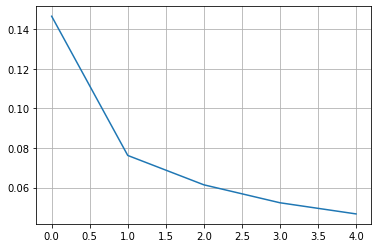

36/36 [==============================] - 1s 5ms/step - loss: 0.0000e+00


In [ ]:
# LSTM
# with tf.device('/device:GPU:0'):
model = Sequential()
model.add(LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, activation='relu'))
model.add(Dropout(dropout_ratio)) 
# model.add(LSTM(128, return_sequences=True, activation="relu"))
# model.add(Dropout(dropout_ratio)) 
model.add(LSTM(16, return_sequences=False, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(Dense(3))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()
model_fit = model.fit(X_train, Y_train, 
                      batch_size=batch_size, epochs=epoch,
                      verbose=verbose)

plt.plot(pd.DataFrame(model_fit.history))
plt.grid(True)
plt.show()

# prediction
Y_train_pred = model.predict(X_train)
Y_test_pred = model.predict(X_test)

# evaluation
result = model.evaluate(X_test, Y_test_pred)
# if scaler != []:
#     Y_train = scaler.inverse_transform(Y_train)
#     Y_train_pred = scaler.inverse_transform(Y_train_pred)
#     Y_test = scaler.inverse_transform(Y_test)
#     Y_test_pred = scaler.inverse_transform(Y_test_pred)
# Score_LSTM, Residual_tr, Residual_te = evaluation_trte(pd.DataFrame(Y_train), Y_train_pred.flatten(), 
#                                                       pd.DataFrame(Y_test), Y_test_pred.flatten(), graph_on=True)
# display(Score_LSTM)

# error analysis
# error_analysis(Residual_te, ['Error'], pd.DataFrame(X_train.reshape(X_train.shape[0], X_train.shape[1])), graph_on=True)

In [ ]:
# prediction
# Y_train_pred = model.predict(X_train)
Y_test_pred = model.predict(X_test)

# # evaluation
# result = model.evaluate(X_test_a, Y_test_pred)

Y_test_pred
# Y_test_pred[:,0].mean(), Y_test_pred[:,1].mean(), Y_test_pred[:,2].mean()

array([[ 0.7490121 , -0.09192742,  0.28116995],
       [-0.0295599 ,  1.098648  , -0.03829005],
       [ 0.00496428,  0.13168696,  0.84811777],
       ...,
       [ 0.7854265 ,  0.0175014 ,  0.24295655],
       [ 0.0686049 ,  0.8146117 ,  0.09408709],
       [-0.04260239,  0.07432953,  0.9169396 ]], dtype=float32)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 4, 32)             4032      
_________________________________________________________________
dropout (Dropout)            (None, 4, 32)             0         
_________________________________________________________________
gru_1 (GRU)                  (None, 16)                2400      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 3)                 51        
Total params: 6,483
Trainable params: 6,483
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
300/300 [==============================] - 38s 91ms/step - loss: 0.1864
Epoch 2/5
300/300 [===================

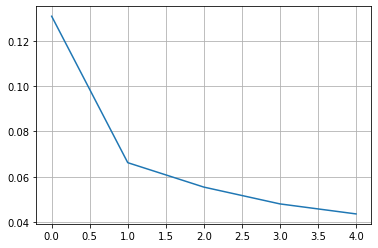

33/33 [==============================] - 1s 3ms/step - loss: 0.0000e+00


In [ ]:
# GRU
# with tf.device('/device:GPU:0'):
model = Sequential()
model.add(GRU(32, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, activation='relu'))
model.add(Dropout(dropout_ratio)) 
# model.add(GRU(256, return_sequences=True, activation="relu"))
# model.add(Dropout(dropout_ratio)) 
# model.add(GRU(128, return_sequences=True, activation="relu"))
# model.add(Dropout(dropout_ratio)) 
model.add(GRU(16, return_sequences=False, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(Dense(3))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()
model_fit = model.fit(X_train, Y_train, 
                      batch_size=batch_size, epochs=epoch,
                      verbose=verbose)

plt.plot(pd.DataFrame(model_fit.history))
plt.grid(True)
plt.show()

# prediction
Y_train_pred = model.predict(X_train)
Y_test_pred = model.predict(X_test)

# evaluation
result = model.evaluate(X_test, Y_test_pred)
# if scaler != []:
#     Y_train = scaler.inverse_transform(Y_train)
#     Y_train_pred = scaler.inverse_transform(Y_train_pred)
#     Y_test = scaler.inverse_transform(Y_test)
#     Y_test_pred = scaler.inverse_transform(Y_test_pred)
# Score_GRU, Residual_tr, Residual_te = evaluation_trte(pd.DataFrame(Y_train), Y_train_pred, 
#                                                       pd.DataFrame(Y_test), Y_test_pred, graph_on=True)
# display(Score_GRU)

# # error analysis
# error_analysis(Residual_te, ['Error'], pd.DataFrame(X_train.reshape(X_train.shape[0], X_train.shape[1])), graph_on=True)

In [ ]:
# prediction
Y_train_pred = model.predict(X_train)
# Y_test_pred = model.predict(X_test)

# # evaluation
# result = model.evaluate(X_test_a, Y_test_pred)

Y_train_pred
# Y_test_pred

# Y_test_pred[:,0].mean(), Y_test_pred[:,1].mean(), Y_test_pred[:,2].mean()

array([[ 1.0112829 , -0.03642473,  0.06247383],
       [-0.02140309,  0.9427316 ,  0.0493685 ],
       [ 0.05671174, -0.0120296 ,  0.93993187],
       ...,
       [ 0.9503317 , -0.11450075,  0.19628632],
       [-0.03033249,  0.9014447 ,  0.07251298],
       [ 0.26795328,  0.12299843,  0.6673869 ]], dtype=float32)

In [ ]:
# X_test
X_train

array([[[1.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.66666667, 0.        , 1.        , ..., 0.        ,
         0.        , 0.        ],
        [0.66666667, 1.        , 0.        , ..., 0.        ,
         1.        , 0.        ],
        [0.66666667, 0.5       , 1.        , ..., 0.        ,
         0.8       , 0.        ]],

       [[1.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [1.        , 1.        , 0.        , ..., 0.        ,
         0.        , 1.        ],
        [1.        , 0.5       , 1.        , ..., 0.        ,
         1.        , 0.        ],
        [0.73684211, 0.        , 0.        , ..., 0.        ,
         0.8       , 0.        ]],

       [[1.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.73684211, 1.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.73684211, 0.5       , 0. 

In [ ]:
agent_load_test = load_agent('/contents/MyDrive/Colab_Notebooks/projects/NCPW/RL/agent/DQN_agent_[10_15_20_20]_test2.ptb')

logs_test = []
for _ in range(300):
  log = json.loads(get_single_play_log(agent_load_test)['states'])
  logs_test+=log

df_test = pd.DataFrame(logs_test)     
test_scaled = scaler.fit_transform(df_test)  

X_test_test = []
for index in range(len(test_scaled) - sequence):
    X_test_test.append(test_scaled[index: index + sequence])

## Retype and Reshape
X_test_test = np.array(X_test_test)
print('X_test_test:', X_test_test.shape)

X_test_test: (12373, 4, 8)


In [ ]:
result = model.predict(X_test_test)
result

array([[-0.01226191,  1.0347848 ,  0.03124857],
       [-0.00692205,  1.0568798 , -0.00246641],
       [ 0.01154498,  1.0293908 ,  0.02055264],
       ...,
       [-0.0982015 ,  0.9838391 , -0.0101915 ],
       [-0.01539788,  0.9665281 , -0.02346746],
       [ 0.12531675,  1.0158839 , -0.07319714]], dtype=float32)

In [ ]:
result[:,0].mean(), result[:,1].mean(), result[:,2].mean()

(-0.013199004, 0.94996226, 0.06165413)

In [ ]:
model = None

In [ ]:
model.save('/contents/MyDrive/Colab_Notebooks/projects/NCPW/Classification/GRU_model_240')

INFO:tensorflow:Assets written to: /contents/MyDrive/Colab_Notebooks/projects/NCPW/Classification/GRU_model_240/assets


In [ ]:
model = tf.keras.models.load_model('/contents/MyDrive/Colab_Notebooks/projects/NCPW/Classification/GRU_model_240')